In [177]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score
import seaborn as sns
import numpy as np 
import pandas as pd 
import os


In [178]:
# Utilisation de GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Flip the image horizontally
        transforms.RandomRotation(15),     # Rotate the image by ±15 degrees
        transforms.RandomCrop((224, 224), padding=10),  # Crop with padding
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust lighting
        transforms.ToTensor(),             # Convert PIL Image to Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ]),
    'test': transforms.Compose([
        transforms.CenterCrop((224, 224)),  # Keep central portion of the image
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
}

In [179]:
# Charger les jeux de données
train_dataset = datasets.ImageFolder('/kaggle/input/skin-cancer-malignant-vs-benign/train', transform=transform["train"])
test_dataset = datasets.ImageFolder('/kaggle/input/skin-cancer-malignant-vs-benign/test', transform=transform["test"])

In [180]:

# Division des données d'entraînement en ensembles d'entraînement et de validation
train_size = int(0.8 * len(train_dataset))  # 80% pour l'entraînement
val_size = len(train_dataset) - train_size  # 20% pour la validation

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [181]:
# Modèles pré-entraînés
efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1').to(device)
mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1').to(device)

In [182]:
# Remplacer la dernière couche pour la classification binaire
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 1).to(device)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 1).to(device)

In [183]:


# Fonction pour entraîner le modèle avec validation et early stopping
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=3):
    best_val_loss = float('inf')
    epochs_without_improvement = 0  # Compter le nombre d'époques sans amélioration
    model.train()
        # Suivi des pertes et des précisions
    train_losses = []
    val_losses = []
   
    for epoch in range(epochs):
        # Entraînement
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
           
            optimizer.zero_grad()  # Réinitialiser les gradients
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())  # Loss binaire
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
       
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

          
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())  # Loss binaire
                val_loss += loss.item()
       
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
       
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0  # Réinitialiser le compteur
        else:
            epochs_without_improvement += 1
       
        if epochs_without_improvement >= patience:
            print("Early stopping triggered")
            break
       
        model.train()

    return model, train_losses, val_losses
        
   

In [184]:
# Définir la fonction de perte et l'optimiseur
criterion = nn.BCEWithLogitsLoss()  # Fonction de perte pour la classification binaire
optimizer_efficientnet = optim.Adam(efficientnet.parameters(), lr=1e-4,weight_decay=1e-5)
optimizer_mobilenet = optim.Adam(mobilenet.parameters(), lr=1e-4,weight_decay=1e-5)




In [185]:
mobilenet_trained, train_losses_mobilenet, val_losses_mobilenet = train_model_with_validation(
    mobilenet, train_loader, val_loader, criterion, optimizer_mobilenet, epochs=32, patience=3)

Epoch 1/32, Train Loss: 0.4210, Val Loss: 0.3505
Epoch 2/32, Train Loss: 0.3126, Val Loss: 0.3341
Epoch 3/32, Train Loss: 0.2776, Val Loss: 0.2685
Epoch 4/32, Train Loss: 0.2335, Val Loss: 0.3047
Epoch 5/32, Train Loss: 0.2229, Val Loss: 0.2762
Epoch 6/32, Train Loss: 0.1953, Val Loss: 0.3073
Early stopping triggered


In [186]:
### Entraîner les deux modèles avec validation et early stopping
efficientnet_trained, train_losses_efficientnet, val_losses_efficientnet = train_model_with_validation(
    efficientnet, train_loader, val_loader, criterion, optimizer_efficientnet, epochs=32, patience=3)

Epoch 1/32, Train Loss: 0.5252, Val Loss: 0.3554
Epoch 2/32, Train Loss: 0.3438, Val Loss: 0.2865
Epoch 3/32, Train Loss: 0.2895, Val Loss: 0.2699
Epoch 4/32, Train Loss: 0.2453, Val Loss: 0.2880
Epoch 5/32, Train Loss: 0.2233, Val Loss: 0.2558
Epoch 6/32, Train Loss: 0.2078, Val Loss: 0.2868
Epoch 7/32, Train Loss: 0.1793, Val Loss: 0.2451
Epoch 8/32, Train Loss: 0.1612, Val Loss: 0.2482
Epoch 9/32, Train Loss: 0.1347, Val Loss: 0.2985
Epoch 10/32, Train Loss: 0.1419, Val Loss: 0.3116
Early stopping triggered


In [187]:
# Fonction de visualisation des courbes de perte
def plot_loss_curves(train_losses, val_losses, model_name):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves for {model_name}')
    plt.legend()
    plt.show()

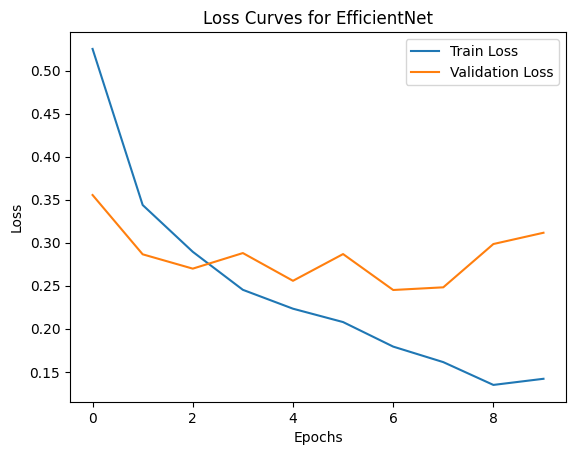

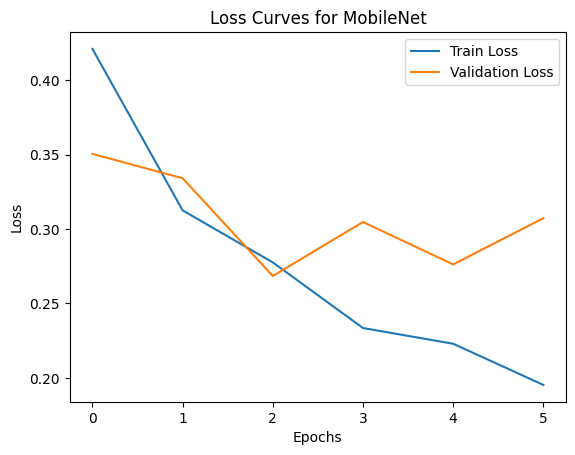

In [188]:
# Courbes de perte pour EfficientNet et MobileNet
plot_loss_curves(train_losses_efficientnet, val_losses_efficientnet, 'EfficientNet')
plot_loss_curves(train_losses_mobilenet, val_losses_mobilenet, 'MobileNet')

In [189]:
# Fonction pour tester le modèle et afficher les résultats
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).squeeze() > 0.5  # Seuil pour la classification binaire
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            scores.extend(torch.sigmoid(outputs).squeeze().cpu().numpy())
   
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")
   
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=["Benign", "Malignant"], yticklabels=["Negative", "Positive"])
    plt.title("Confusion Matrix")
    plt.show()

    # Compute ROC and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, scores)
    auc = roc_auc_score(all_labels, scores)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


Evaluating EfficientNet:
Accuracy: 0.8924


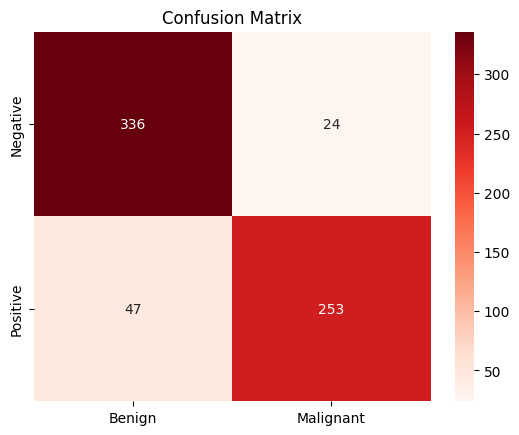

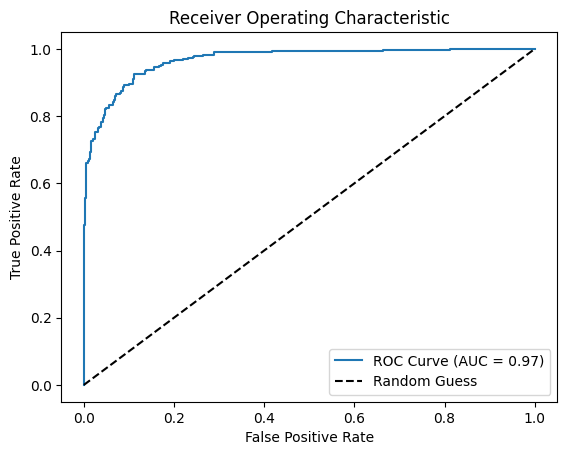

Evaluating MobileNet:
Accuracy: 0.8833


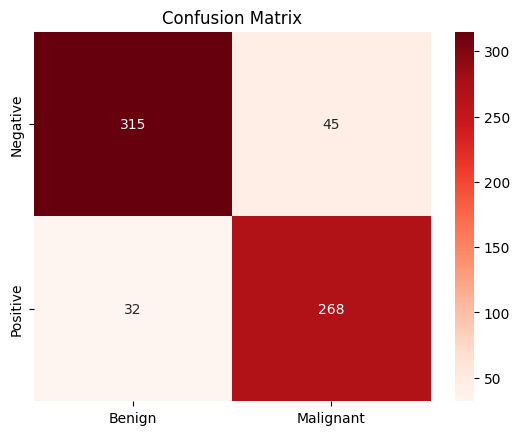

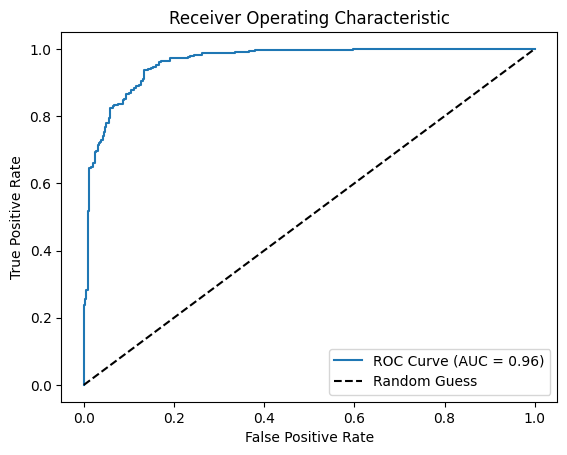

In [190]:
# Évaluation des modèles sur l'ensemble de test
print("Evaluating EfficientNet:")
evaluate_model(efficientnet_trained, test_loader)

print("Evaluating MobileNet:")
evaluate_model(mobilenet_trained, test_loader)